# C. Site Characteristics

#### Some Preprocessing and Data CheckUps

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("data/charging_sessions.csv")
df_weather = pd.read_csv("data/cleaned_weather_data.csv")

In [13]:
df_weather.dtypes

Unnamed: 0                   int64
timestamp                   object
temperature                float64
cloud_cover                float64
cloud_cover_description     object
pressure                   float64
windspeed                  float64
precipitation              float64
felt_temperature           float64
dtype: object

In [18]:
df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce')
df['connectionTime'] = df['connectionTime'].dt.tz_convert('America/Los_Angeles')

df['chargingDuration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], utc=True)


### Compare Charging durations

In [4]:
# Compare average charging duration and kWh delivered for each site
site_stats = df.groupby('siteID')[['chargingDuration', 'kWhDelivered']].mean()
print(site_stats)


        chargingDuration  kWhDelivered
siteID                                
1               6.866313     14.063156
2               5.653222      9.249425


### Compare missing user IDs

   siteID  userID_missing
0       1            2227
1       2           15036


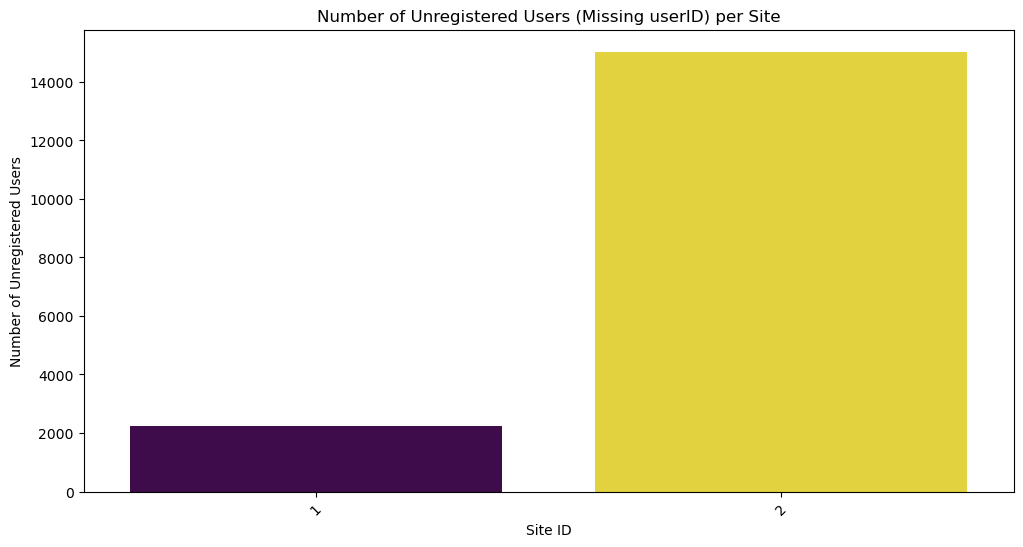

In [27]:
# Create a column indicating if the userID is missing (i.e., unregistered)
df['userID_missing'] = df['userID'].isnull()

# Count the number of unregistered users (missing userID) for each site
unregistered_users_per_site = df.groupby('siteID')['userID_missing'].sum().reset_index()
print(unregistered_users_per_site)

# Plot the number of unregistered users for each site
plt.figure(figsize=(12, 6))
sns.barplot(x='siteID', y='userID_missing', hue='siteID', data=unregistered_users_per_site, palette='viridis', dodge=False, legend=False)
plt.title('Number of Unregistered Users (Missing userID) per Site')
plt.xlabel('Site ID')
plt.ylabel('Number of Unregistered Users')
plt.xticks(rotation=45)
plt.show()

#### Site 1:
Has a lower number of unregistered users, likely because it is a private hub where users are required to register or obtain authorization for access before charging.

#### Site 2:
The high number of sessions with missing user information at Site 2 suggests that the site serves many unregistered or occasional users, possibly due to being a more publicly accessible charging station.

### Compare Charging over Time

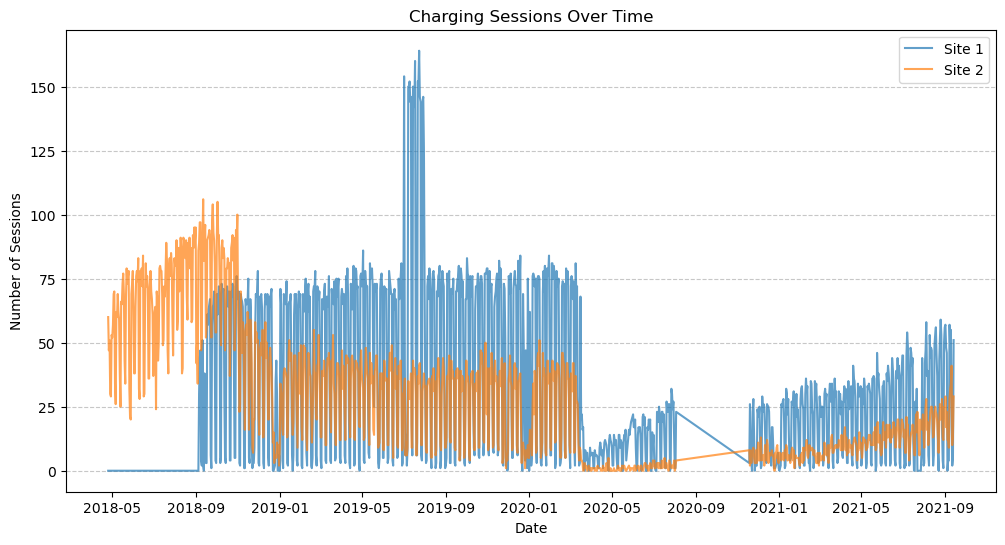

In [30]:
df['connection_date'] = df['connectionTime'].dt.date

# Aggregate charging sessions per day
charging_sessions_per_day = df.groupby(['connection_date', 'siteID']).size().unstack(fill_value=0)

# Plot charging sessions over time
plt.figure(figsize=(12, 6))
for siteID in charging_sessions_per_day.columns:
    charging_sessions_per_day[siteID].plot(label=f'Site {siteID}', alpha=0.7)
plt.title('Charging Sessions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Site 1:
Has a higher number of charging sessions, which suggests that it may experience greater demand or serve a larger user base, possibly due to better accessibility or higher usage rates.

#### Site 2:
Has a lower number of charging sessions, with a noticeable drop-off after Site 1 opened. This suggests that users may be shifting to Site 1, potentially due to factors like better facilities, location, or convenience offered at Site 1, leading to a decline in Site 2's activity.

### Compare charging times

Unique siteID values: [1 2]


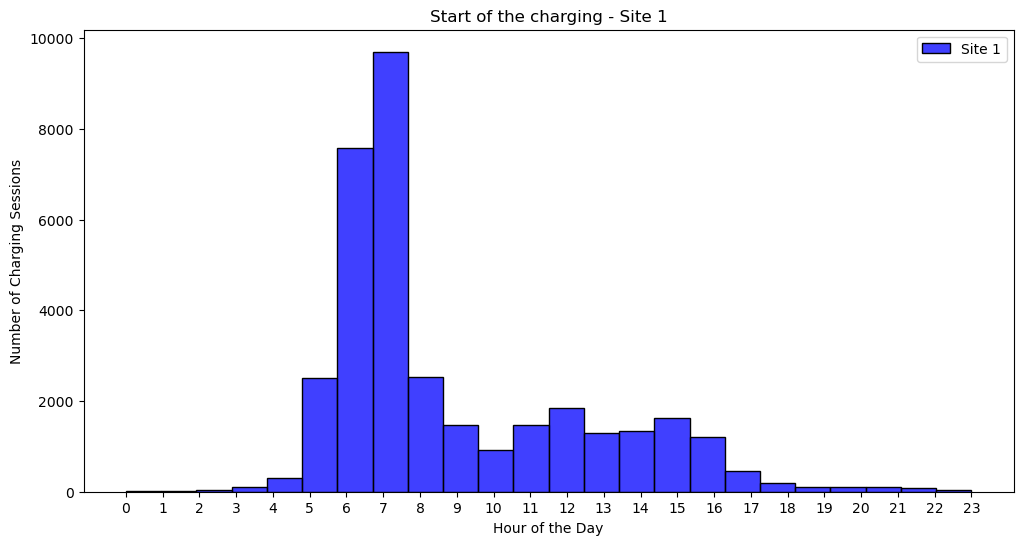

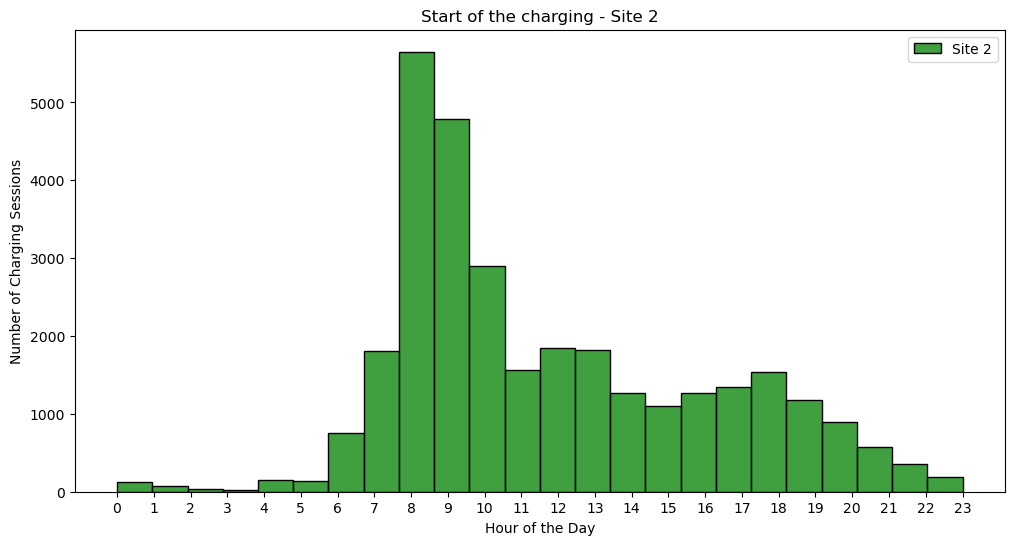

In [31]:

# Debugging: Check unique values in siteID
print("Unique siteID values:", df['siteID'].unique())

# Extract hour of the day from connectionTime
df['chargingHour'] = df['connectionTime'].dt.hour

# Separate the data for each site
site1_data = df[df['siteID'] == 1]  # Adjust the value if needed
site2_data = df[df['siteID'] == 2]  # Adjust the value if needed

# Plot charging hours for Site 1
plt.figure(figsize=(12, 6))
sns.histplot(site1_data['chargingHour'].dropna(), bins=24, kde=False, color='blue', label='Site 1')
plt.title('Start of the charging - Site 1')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Charging Sessions')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

# Plot charging hours for Site 2
plt.figure(figsize=(12, 6))
sns.histplot(site2_data['chargingHour'].dropna(), bins=24, kde=False, color='green', label='Site 2')
plt.title('Start of the charging - Site 2')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Charging Sessions')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

#### Site 1:
Charging times at Site 1 are more concentrated, with clear peaks during specific hours. This pattern reflects a predictable usage schedule, typical of private hubs, where users—such as employees charging during work hours or residents charging overnight—follow a regular routine. This regularity indicates that Site 1 is primarily used by a consistent group of users with well-established charging habits.

#### Site 2:
In contrast, the charging times at Site 2 show greater variability, suggesting it is a public charging hub where usage is driven by more sporadic and diverse demand. Public hubs tend to see less predictable patterns, as customers charge their vehicles on-demand, leading to a more spread-out usage throughout the day.

### Compare charging durations

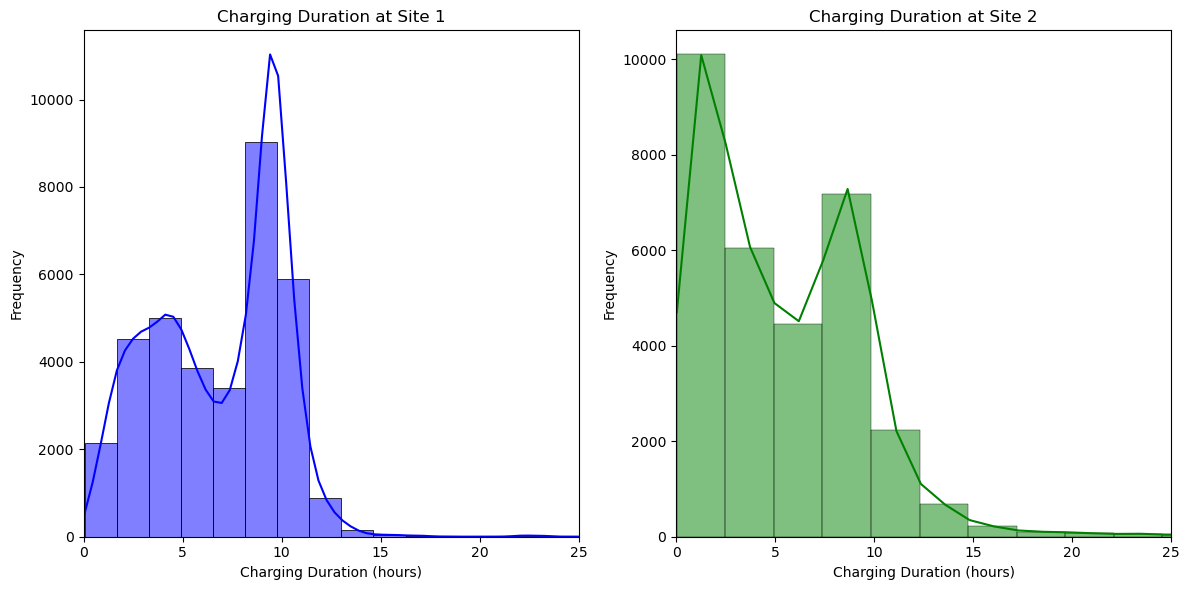

In [32]:

# Filter data for each site
site1_data = df[df['siteID'] == 1]
site2_data = df[df['siteID'] == 2]

# Plot histograms or density plots
plt.figure(figsize=(12, 6))

# Site 1
plt.subplot(1, 2, 1)
sns.histplot(site1_data['chargingDuration'], bins=50, kde=True, color='blue')
plt.title("Charging Duration at Site 1")
plt.xlabel("Charging Duration (hours)")
plt.ylabel("Frequency")
plt.xlim(0, 25) 

# Site 2
plt.subplot(1, 2, 2)
sns.histplot(site2_data['chargingDuration'], bins=100, kde=True, color='green')
plt.title("Charging Duration at Site 2")
plt.xlabel("Charging Duration (hours)")
plt.ylabel("Frequency")
plt.xlim(0, 25) 

plt.tight_layout()
plt.show()


#### Site 1:
Longer charging durations are characteristic of private hubs, where users—such as employees or residents—tend to leave their vehicles plugged in for extended periods, often during work hours or overnight. This behavior reflects an environment where users have predictable access to charging and aren’t under pressure to vacate the station quickly.

#### Site 2:
Shorter charging durations at Site 2 are indicative of a public hub, where users typically charge their vehicles only enough to continue their journey. These hubs tend to experience higher turnover, prioritizing quick access for multiple users, which suits the needs of transient or occasional customers.

### Compare number of visits per customer

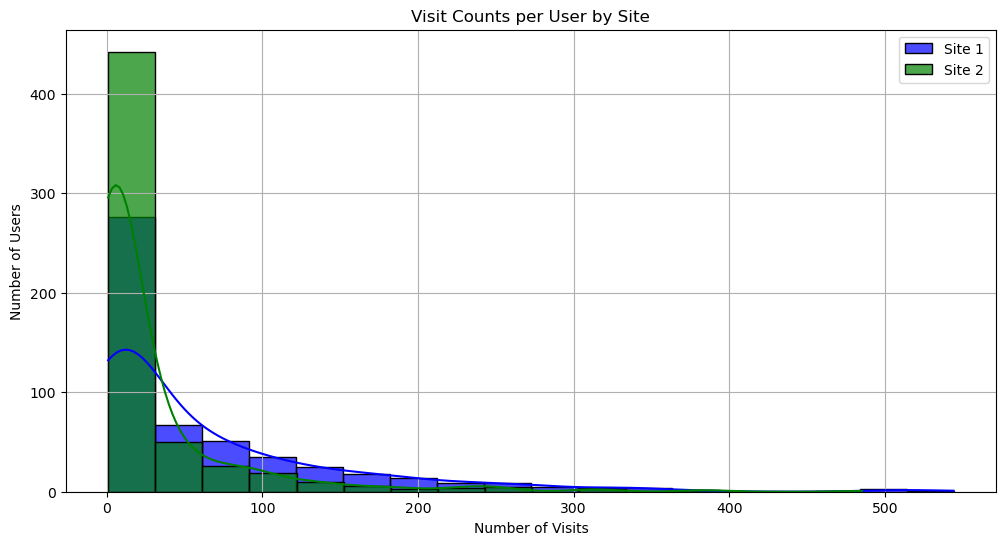

In [33]:
visit_counts = df.groupby(['siteID', 'userID']).size().reset_index(name='visit_count')

# Trenne die Daten für jede Site
site1_visits = visit_counts[visit_counts['siteID'] == 1]
site2_visits = visit_counts[visit_counts['siteID'] == 2]

# Erstelle das Histogramm mit KDE
plt.figure(figsize=(12, 6))

# Histogramm mit KDE für Site 1
sns.histplot(data=site1_visits, x='visit_count', kde=True, color='blue', label='Site 1', binwidth=30, alpha=0.7)

# Histogramm mit KDE für Site 2
sns.histplot(data=site2_visits, x='visit_count', kde=True, color='green', label='Site 2', binwidth=30, alpha=0.7)

# Diagramm formatieren
plt.title("Visit Counts per User by Site")
plt.xlabel("Number of Visits")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(True)
plt.show()


#### Site 1:
Has a higher proportion of frequent users compared to Site 2. This suggests that Site 1 likely caters to a consistent user base, such as employees or residents, who rely on this charging hub regularly.

#### Site 2:
Has fewer frequent users, indicating that the site serves a more diverse and transient customer base, likely driven by occasional or on-demand charging needs.

### Compare charging sessions across the seasons

C:\Users\Jan\AppData\Local\Temp\ipykernel_6152\3907703552.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


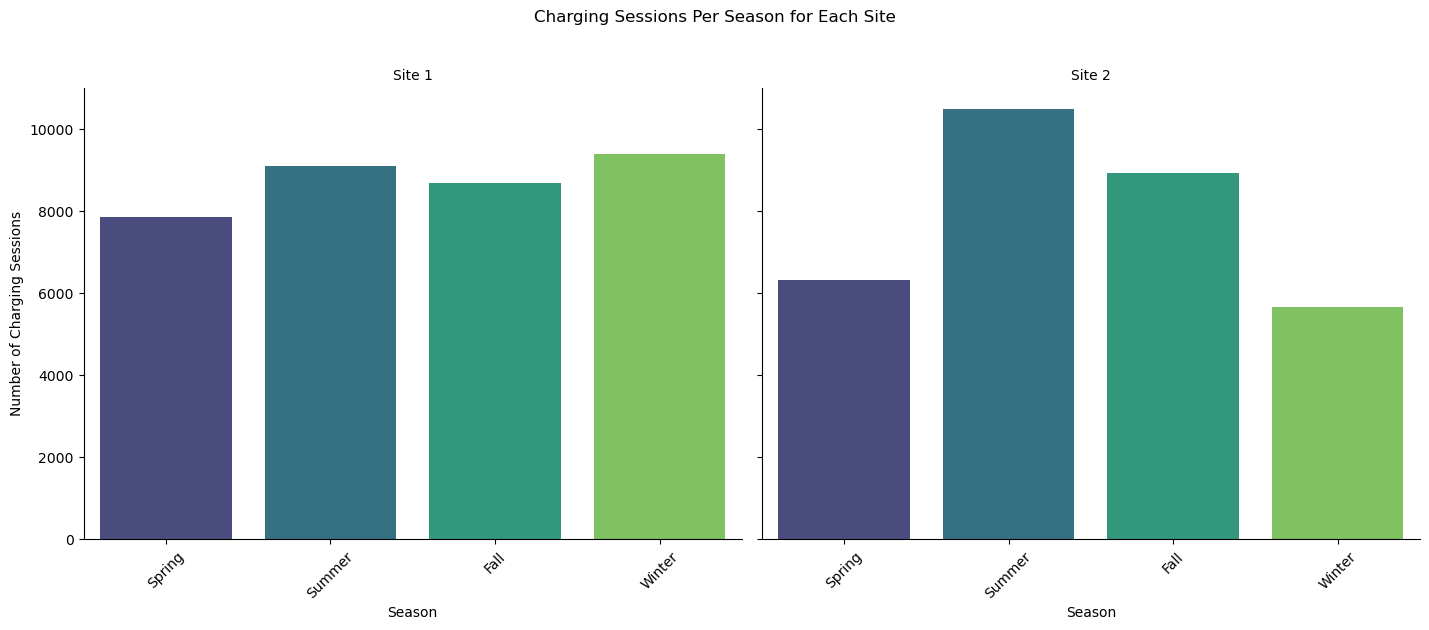

In [10]:

# extract the month
df['month'] = df['connectionTime'].dt.month

# Define the seasons based on months
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df['season'] = df['month'].apply(get_season)

# Define the custom order for seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Group the data by season and site
season_data = df.groupby(['season', 'siteID']).size().reset_index(name='session_count')

# Create a FacetGrid to plot the two sites side by side
g = sns.catplot(
    data=season_data,
    x='season',
    y='session_count',
    col='siteID',
    kind='bar',
    order=season_order,
    height=6,
    aspect=1.2,
    palette='viridis',
    sharey=True  # Ensures both plots have the same y-axis scale
)

# Customize the plot
g.set_titles("Site {col_name}")
g.set_axis_labels("Season", "Number of Charging Sessions")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Charging Sessions Per Season for Each Site")

plt.show()


#### Site 1:
Shows a relatively even distribution of usage across the seasons, indicating that the charging patterns are not heavily impacted by external seasonal factors. This consistency is typical for private hubs, where users rely on the charging station as part of their routine, regardless of the time of year.

#### Site 2:
Experiences greater seasonal variations in usage, with peaks in summer and fall. These fluctuations suggest that Site 2 is influenced by factors such as seasonal travel, leisure activities, or tourist traffic, all of which are common for public hubs.

# Conclusion:

## Site 1:
The concentrated charging times, longer charging durations, higher frequency of registered users, and consistent seasonal distribution all point to the conclusion that Site 1 functions as a private charging hub. It serves a stable and routine-oriented user base, such as employees or residents, who rely on the station for predictable, regular charging.



## Site 2:
In contrast, the greater variability in charging times, shorter charging durations, higher proportion of unregistered users, and seasonal usage peaks indicate that Site 2 is a public charging hub. This site primarily serves occasional users, including tourists or transient customers, with demand driven by more sporadic, on-demand charging needs and external seasonal factors.